In [49]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB         # Naive Bayes
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer

import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
#nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer

import RAKE
import operator
from rake_nltk import Rake


from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
#corpus_root = '/Users/reesj/Desktop/varmus-nlp-tests/jpr_play/text-out/'
corpus_root = '/Users/reesj/Desktop/varmus-nlp-tests/jpr_play/text-out-2/'

In [3]:
from collections import defaultdict
from pathlib import Path

In [4]:
# create a corpus by walking through a directory of files, open each file and read filename and text into a 2 column dataframe
corpus = defaultdict(list)
for file in Path(corpus_root).iterdir():
    with open(file, "r") as file_open:
        corpus["file_name"].append(file.name)
        corpus["text"].append(file_open.read())
df = pd.DataFrame(corpus)


print(df)
#print(corpus['file_name'])

                               file_name  \
0         00-email request to HV.doc.txt   
1    1% Transfer - NIDCR - Candida f.txt   
2                              1.txt.txt   
3                       10-13e~1.doc.txt   
4           101GUID1update-fnl-1.doc.txt   
..                                   ...   
605      Proposal for an Institute v.txt   
606  proposal for Wnt-1, Brca1 cross.txt   
607                     proposal.doc.txt   
608                  PROPOSALNIH.doc.txt   
609   Proposed expts; 1999 meeting.txt   

                                                  text  
0                                                       
1    Functional Genomics: Candida AlbicansFY 00 Cos...  
2                                                       
3    E-MAILE-mail:  hv2b@nih.gov\nDear Harold:\nIt ...  
4    Guidelines for Examination of Applications for...  
..                                                 ...  
605  Proposal for an Institute for Directed Molecul...  
606  Hyposthesi

In [5]:
# replace \n newlines with a space
df['text'] = df['text'].replace(r'\n',' ', regex=True)
print(df)

                               file_name  \
0         00-email request to HV.doc.txt   
1    1% Transfer - NIDCR - Candida f.txt   
2                              1.txt.txt   
3                       10-13e~1.doc.txt   
4           101GUID1update-fnl-1.doc.txt   
..                                   ...   
605      Proposal for an Institute v.txt   
606  proposal for Wnt-1, Brca1 cross.txt   
607                     proposal.doc.txt   
608                  PROPOSALNIH.doc.txt   
609   Proposed expts; 1999 meeting.txt   

                                                  text  
0                                                       
1    Functional Genomics: Candida AlbicansFY 00 Cos...  
2                                                       
3    E-MAILE-mail:  hv2b@nih.gov Dear Harold: It wa...  
4    Guidelines for Examination of Applications for...  
..                                                 ...  
605  Proposal for an Institute for Directed Molecul...  
606  Hyposthesi

In [6]:
df['text'].head()

0                                                     
1    Functional Genomics: Candida AlbicansFY 00 Cos...
2                                                     
3    E-MAILE-mail:  hv2b@nih.gov Dear Harold: It wa...
4    Guidelines for Examination of Applications for...
Name: text, dtype: object

In [7]:
#Fetch wordcount for each text
df['word_count'] = df['text'].apply(lambda x: len(str(x).split(" ")))
df[['text','word_count']].head()



,text,word_count
0,,1
1,Functional Genomics: Candida AlbicansFY 00 Cos...,1206
2,,1
3,E-MAILE-mail: hv2b@nih.gov Dear Harold: It wa...,416
4,Guidelines for Examination of Applications for...,2231


In [8]:
##Descriptive statistics of word counts
df.word_count.describe()


count      610.000000
mean      1244.786885
std       2853.017335
min          1.000000
25%        124.250000
50%        488.500000
75%       1367.000000
max      57001.000000
Name: word_count, dtype: float64

There are 182 texts  
The average word count per text is 785  
The largest text has 7,167 words  

In [9]:
#Identify common words
freq = pd.Series(' '.join(df['text']).split()).value_counts()[:20]
freq

the         35348
of          28769
and         23848
to          19653
in          14595
a           10066
for          9242
that         7316
be           6922
is           6645
with         4956
The          4805
by           4474
are          4241
will         4199
as           4111
on           4022
or           3471
research     3146
this         2968
dtype: int64

In [10]:
#Identify uncommon words
freq1 =  pd.Series(' '.join(df 
         ['text']).split()).value_counts()[-20:]
freq1

723-1399            1
38A,                1
interfaceable       1
underway)           1
(already            1
Database:           1
$3M/year            1
importation.        1
repository(ies)     1
$1.5M/year          1
resource(s)         1
gamete              1
(most/each)         1
sessions/year/10    1
$200K/year          1
video/manual        1
Enable              1
Outreach.           1
$1M/lab             1
Dalhousie           1
dtype: int64

In [11]:
##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))

In [69]:
stop_words = set(stopwords.words("english"))

corpus = []
for i in range(0, 610):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', df['text'][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    ##Stemming
    #ps=PorterStemmer()
    ps=SnowballStemmer('english')
    
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

In [59]:
#View a corpus item
corpus[22]

'july october federal policy research misconduct protect integrity research record q internal use q announced today office science technology policy conjunction office management budget issuing draft government wide federal policy addressing research misconduct policy address behavior potential affect integrity research record establishes procedural safeguard handling allegation research misconduct cleared national science technology council result extensive interagency development review clearance process initiated april policy consists definition research misconduct guideline handling allegation research misconduct following consideration public comment received agency directed implement policy q taken long policy released great care taken ensure unique mission responsibility agency considered policy result extensive interagency consultation development government wide policy research misconduct national science technology council includes federal agency engaged research q covered po

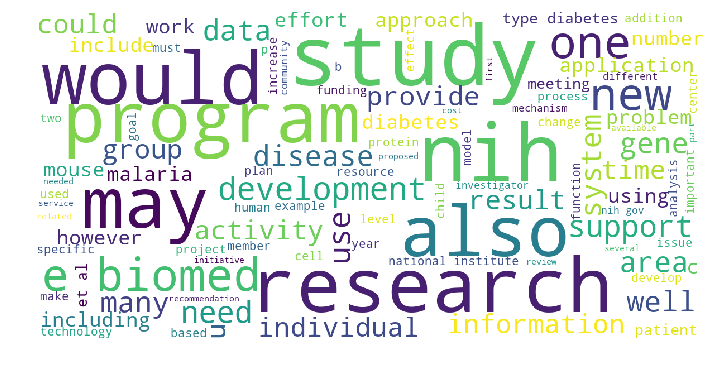

In [60]:
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42,
                        scale=3,
                         ).generate(str(corpus))
print(wordcloud)
fig = plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
#fig.savefig("word1.png", dpi=900)

In [70]:
#use the CountVectoriser to tokenise the text and build a vocabulary of known words. 
#We first create a variable “cv” of the CountVectoriser class, 
#and then evoke the fit_transform function to learn and build the vocabulary.

#cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
#X=cv.fit_transform(corpus)

In [62]:
list(cv.vocabulary_.keys())[:22]

['functional',
 'genomics',
 'candida',
 'cost',
 'million',
 'total',
 'project',
 'mechanism',
 'rpgs',
 'justification',
 'fund',
 'requested',
 'director',
 'set',
 'aside',
 'accelerate',
 'scientific',
 'research',
 'albicans',
 'fy',
 'significantly',
 'benefit']

[Text(0, 0, 'research'),
 Text(0, 0, 'nih'),
 Text(0, 0, 'would'),
 Text(0, 0, 'new'),
 Text(0, 0, 'study'),
 Text(0, 0, 'cell'),
 Text(0, 0, 'mouse'),
 Text(0, 0, 'diabetes'),
 Text(0, 0, 'health'),
 Text(0, 0, 'gene'),
 Text(0, 0, 'disease'),
 Text(0, 0, 'also'),
 Text(0, 0, 'system'),
 Text(0, 0, 'year'),
 Text(0, 0, 'program'),
 Text(0, 0, 'development'),
 Text(0, 0, 'review'),
 Text(0, 0, 'human'),
 Text(0, 0, 'one'),
 Text(0, 0, 'may')]

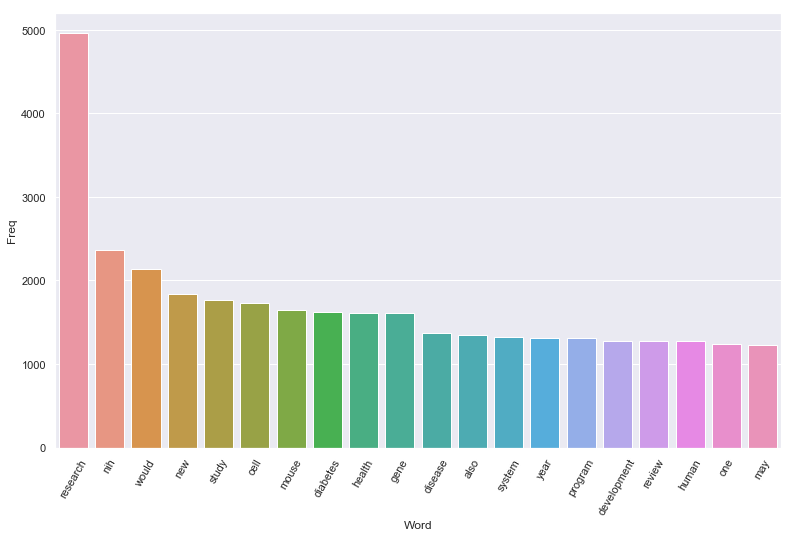

In [75]:
#We can use the CountVectoriser to visualise the top 20 unigrams, bi-grams and tri-grams.

#Function to generate most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]

#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]

#Barplot of most freq words
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=60)

[Text(0, 0, 'type diabetes'),
 Text(0, 0, 'et al'),
 Text(0, 0, 'national institute'),
 Text(0, 0, 'nih gov'),
 Text(0, 0, 'clinical trial'),
 Text(0, 0, 'editorial board'),
 Text(0, 0, 'public health'),
 Text(0, 0, 'research plan'),
 Text(0, 0, 'peer review'),
 Text(0, 0, 'diabetes research'),
 Text(0, 0, 'study section'),
 Text(0, 0, 'research community'),
 Text(0, 0, 'working group'),
 Text(0, 0, 'scientific community'),
 Text(0, 0, 'long term'),
 Text(0, 0, 'clinical research'),
 Text(0, 0, 'research misconduct'),
 Text(0, 0, 'human genome'),
 Text(0, 0, 'united state'),
 Text(0, 0, 'institute health')]

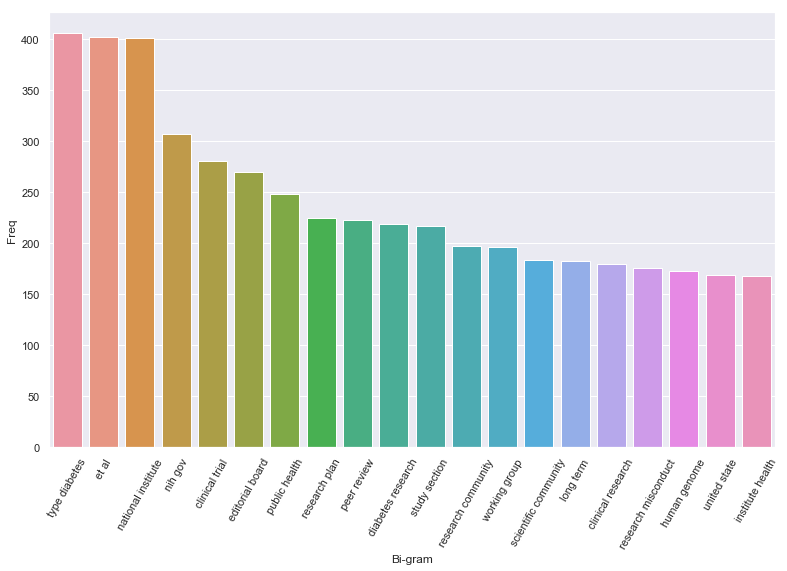

In [64]:
#Function to generate most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
#print(top2_df)

#Barplot of most freq Bi-grams
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=60)

[Text(0, 0, 'national institute health'),
 Text(0, 0, 'zrg ss zrg'),
 Text(0, 0, 'ss zrg ss'),
 Text(0, 0, 'national institute neurological'),
 Text(0, 0, 'institute neurological disorder'),
 Text(0, 0, 'full length cdna'),
 Text(0, 0, 'human genome project'),
 Text(0, 0, 'national cancer institute'),
 Text(0, 0, 'national institute mental'),
 Text(0, 0, 'institute mental health'),
 Text(0, 0, 'neurological disorder stroke'),
 Text(0, 0, 'biomed governing board'),
 Text(0, 0, 'definition research misconduct'),
 Text(0, 0, 'irg irg consider'),
 Text(0, 0, 'irg consider research'),
 Text(0, 0, 'consider research application'),
 Text(0, 0, 'type type diabetes'),
 Text(0, 0, 'tumor suppressor gene'),
 Text(0, 0, 'mutagenesis phenotyping center'),
 Text(0, 0, 'disorder stroke bldg')]

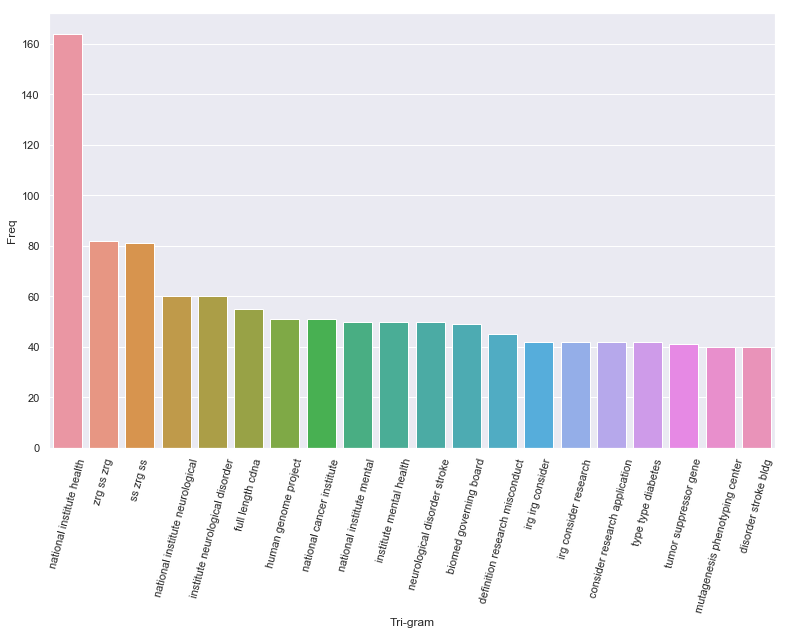

In [65]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(corpus, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
#print(top3_df)

#Barplot of most freq Tri-grams
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=75)

## Generate keywordsfor a document using tf-idf scoring

In [45]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)
# get feature names
feature_names=cv.get_feature_names()
 
# fetch document for which keywords needs to be extracted
doc=corpus[22]
 
#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

In [46]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,15)
 
# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])


Abstract:
july october federal policy research misconduct protect integrity research record q internal use q announced today office science technology policy conjunction office management budget issuing draft government wide federal policy addressing research misconduct policy address behavior potential affect integrity research record establishes procedural safeguard handling allegation research misconduct cleared national science technology council result extensive interagency development review clearance process initiated april policy consists definition research misconduct guideline handling allegation research misconduct following consideration public comment received agency directed implement policy q taken long policy released great care taken ensure unique mission responsibility agency considered policy result extensive interagency consultation development government wide policy research misconduct national science technology council includes federal agency engaged research q 

## Generate keywords for the whole corpus using tf-idf scoring

In [22]:
# corpus code to come

## Generate keyphrases using RAKE

In [23]:
stop_dir = '/Users/reesj/Desktop/varmus-nlp-tests/SmartStoplist.txt'
rake_object = RAKE.Rake(stop_dir)

In [24]:
def Sort_Tuple(tup):
    tup.sort(key = lambda x: x[1])
    return tup

In [48]:
#run function on a single document from the corpus
keywords = Sort_Tuple(rake_object.run(corpus[22]))

#sort the tuple by scores from highest to lowest; highest score is more important
keywords.sort(key=lambda tup: tup[1], reverse=True)

#print results tab-delimited form, keywords|rake score
for q,w in keywords:
    print(f"{q}\t{w}")
    
#print('keywords:', keywords)


authority conduct investigation exercise authority	25.0
case experiment involving human subject	24.0
long policy released great care	23.5
conducting research misuse public fund	23.2
penalty reflects seriousness finding misconduct	23.142857142857142
change replace existing regulation adopt	23.0
definition explicitly cover plagiarism idea	22.666666666666664
agency flexibility meeting agency specific	22.272727272727273
federal fund research institution expected	22.03333333333333
deviation clause specifically defining term	22.0
protection whistleblower achieved policy policy	22.0
action finding research misconduct agency	21.47922077922078
choose implement policy administrative mechanism	20.5
definition research misconduct differ agency	18.645887445887446
federal fund involved institution	17.333333333333332
federal agency providing fund	16.46969696969697
year debarment dr liburdy	16.0
address research misconduct requiring	15.842857142857143
issue research misconduct handled	15.8428571428571

In [26]:
#sort the tuple by scores from highest to lowest; highest score is more important
keywords.sort(key=lambda tup: tup[1], reverse=True)
print(keywords)

[('authority conduct investigation exercise authority', 25.0), ('case experiment involving human subject', 24.0), ('long policy released great care', 23.5), ('conducting research misuse public fund', 23.2), ('penalty reflects seriousness finding misconduct', 23.142857142857142), ('change replace existing regulation adopt', 23.0), ('definition explicitly cover plagiarism idea', 22.666666666666664), ('agency flexibility meeting agency specific', 22.272727272727273), ('federal fund research institution expected', 22.03333333333333), ('deviation clause specifically defining term', 22.0), ('protection whistleblower achieved policy policy', 22.0), ('action finding research misconduct agency', 21.47922077922078), ('choose implement policy administrative mechanism', 20.5), ('definition research misconduct differ agency', 18.645887445887446), ('federal fund involved institution', 17.333333333333332), ('federal agency providing fund', 16.46969696969697), ('year debarment dr liburdy', 16.0), ('ad

In [27]:
#make a little more readable
for q,w in keywords:
    print(f"{q}\t{w}")

authority conduct investigation exercise authority	25.0
case experiment involving human subject	24.0
long policy released great care	23.5
conducting research misuse public fund	23.2
penalty reflects seriousness finding misconduct	23.142857142857142
change replace existing regulation adopt	23.0
definition explicitly cover plagiarism idea	22.666666666666664
agency flexibility meeting agency specific	22.272727272727273
federal fund research institution expected	22.03333333333333
deviation clause specifically defining term	22.0
protection whistleblower achieved policy policy	22.0
action finding research misconduct agency	21.47922077922078
choose implement policy administrative mechanism	20.5
definition research misconduct differ agency	18.645887445887446
federal fund involved institution	17.333333333333332
federal agency providing fund	16.46969696969697
year debarment dr liburdy	16.0
address research misconduct requiring	15.842857142857143
issue research misconduct handled	15.8428571428571